## SPark Logistic Regression

In [1]:

import findspark

findspark.init('/opt/spark')
from pyspark.sql import SparkSession



In [2]:
spark = SparkSession.builder.appName('lec15_Log_Reg_moynihanl').getOrCreate()


In [3]:
from pyspark import SparkFiles

url = 'https://raw.githubusercontent.com/BlueJayADAL/DS200/master/datasets/titanic_train.csv'


In [4]:
spark.sparkContext.addFile(url)



In [5]:
fileloc = SparkFiles.get('titanic_train.csv')
fileloc

'/tmp/spark-2489698d-923e-47ba-9f14-9d5aee2fb7a3/userFiles-1921558c-5028-431b-a07b-a3f7a7fda98f/titanic_train.csv'

In [6]:
df = spark.read.csv('file://'+fileloc, inferSchema=True, header=True)

In [9]:
df.printSchema()


root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [10]:
df.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [12]:
import pyspark.sql.functions as F

In [16]:
df.filter(df['Embarked'].isNull()).count()

2

In [18]:
#list comprehension

In [20]:
missing_count = [df.filter(df[col].isNull()).count() for col in df.columns]
missing_count

[0, 0, 0, 0, 0, 177, 0, 0, 0, 0, 687, 2]

In [ ]:
## same as missing_data = []
##         for col in data.columns:
##         value = data.filter(data[col].isNull().count())
##         missing_data.append(value)

In [23]:
for i, col in enumerate(df.columns):       #enumerate gives u element and index for that element (a tuple)
    print('{}: {}'.format(col, missing_count[i]))

PassengerId: 0
Survived: 0
Pclass: 0
Name: 0
Sex: 0
Age: 177
SibSp: 0
Parch: 0
Ticket: 0
Fare: 0
Cabin: 687
Embarked: 2


In [25]:
my_df = df.select([
 'Survived',
 'Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Embarked'])

In [26]:
my_final_data = my_df.na.drop()

In [27]:
from pyspark.ml.feature import (VectorAssembler,
                               OneHotEncoder,
                               StringIndexer)

In [28]:
gender_indexer = StringIndexer(inputCol='Sex', outputCol='SexIndex')
gender_encoder = OneHotEncoder(inputCol = 'SexIndex', outputCol='SexVec')

In [29]:
embarked_indexer = StringIndexer(inputCol='Embarked', outputCol='EmbarkedIndex')
embarked_encoder = OneHotEncoder(inputCol = 'EmbarkedIndex', outputCol='EmbarkedVec')

In [31]:
df.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|      

In [32]:
assembler = VectorAssembler(inputCols=['Pclass','SexVec','Age','SibSp','Parch','Fare','EmbarkedVec'],
                           outputCol = 'features')

In [33]:
from pyspark.ml import Pipeline

In [ ]:
## dont need to do fit and transform for each one bc u got this pipeline object

In [34]:
pipeline = Pipeline(stages = [gender_indexer,
                             embarked_indexer,
                             gender_encoder,
                             embarked_encoder,
                             assembler])

In [35]:
my_final_data = pipeline.fit(my_final_data).transform(my_final_data)

In [36]:
my_final_data = my_final_data.select(['features','Survived'])

In [37]:
my_final_data.show()

+--------------------+--------+
|            features|Survived|
+--------------------+--------+
|[3.0,1.0,22.0,1.0...|       0|
|[1.0,0.0,38.0,1.0...|       1|
|(8,[0,2,5,6],[3.0...|       1|
|[1.0,0.0,35.0,1.0...|       1|
|[3.0,1.0,35.0,0.0...|       0|
|[1.0,1.0,54.0,0.0...|       0|
|[3.0,1.0,2.0,3.0,...|       0|
|[3.0,0.0,27.0,0.0...|       1|
|[2.0,0.0,14.0,1.0...|       1|
|[3.0,0.0,4.0,1.0,...|       1|
|(8,[0,2,5,6],[1.0...|       1|
|[3.0,1.0,20.0,0.0...|       0|
|[3.0,1.0,39.0,1.0...|       0|
|(8,[0,2,5,6],[3.0...|       0|
|(8,[0,2,5,6],[2.0...|       1|
|[3.0,1.0,2.0,4.0,...|       0|
|[3.0,0.0,31.0,1.0...|       0|
|[2.0,1.0,35.0,0.0...|       0|
|[2.0,1.0,34.0,0.0...|       1|
|(8,[0,2,5],[3.0,1...|       1|
+--------------------+--------+
only showing top 20 rows



In [ ]:
#to do visualizations u need to do toPanda

In [39]:
train_titanic, test_titanic = my_final_data.randomSplit([0.7,0.3], seed = 101)

In [41]:
from pyspark.ml.classification import LogisticRegression

In [42]:
log_reg_titanic = LogisticRegression(featuresCol='features',
                                    labelCol = 'Survived',
                                    predictionCol = 'prediction')

In [44]:
fit_model = log_reg_titanic.fit(train_titanic)

In [ ]:
## add weight column

In [45]:
results = fit_model.transform(test_titanic)

In [52]:
training_summary = fit_model.summary

ROC = training_summary.roc.toPandas()

In [53]:
ROC

,FPR,TPR
0,0.000000,0.000000
1,0.000000,0.025907
2,0.003257,0.041451
3,0.003257,0.062176
4,0.003257,0.082902
...,...,...
117,0.960912,1.000000
118,0.973941,1.000000
119,0.986971,1.000000
120,1.000000,1.000000


Text(0.5, 1.0, 'ROC Curve')

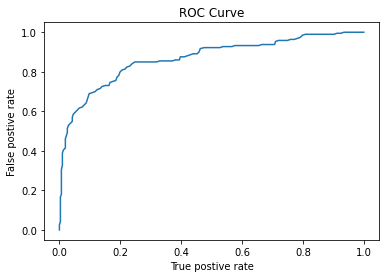

In [56]:
import matplotlib.pyplot as plt
plt.plot(ROC['FPR'], ROC['TPR'])

plt.ylabel('False postive rate')
plt.xlabel('True postive rate')
plt.title("ROC Curve")

In [57]:
training_summary.areaUnderROC

0.8669727093213613

In [59]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [60]:
my_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='Survived')

In [62]:
my_eval.evaluate(results) ##evaluator on testing

0.7832658569500675